# Code to take data using the scope and plot relevant histograms. Will output energy resolution and associated errors.

In [1]:
import os
import sys
import pyvisa as visa

import importlib
#import time
import h5py # This is the python library that creates files/stores data sets
import numpy as np
import matplotlib.pyplot as plt

#Local scripts
import MSO4102Bastro as sdaq # This is the scope module that Sean G. wrote. You will need this module (should be on GitHub, https://github.com/ibrewer/scope-daq)
import readData

### Enter the IP address of the scope as a string. The IP address of the scope should be set by the router (make sure both the scope and the lab laptop are plugged into the router). To check the IP address of the scope, you can go to the Utility menu and check the LAN settings. Sometimes a LAN reset is required.

In [2]:
scope = sdaq.Scope(address="169.254.2.185")

Define output file and data set names

In [3]:
path='../dataOut/102221_amp1/'
if not os.path.exists(path):
    os.makedirs(path)
outName='test2'
dsName='run1'
#scope.set_source_channel(0) #Set scope channel to read - same as displayed on scope
traces=100
minutes=0.25

Boolean run options

In [4]:
savePlots=True 

### This command creates a h5py file, desginated as "f." Documentation for h5py can be found at http://docs.h5py.org/en/stable/. 
### NOTE: Please keep the 'a' flag.  ***Also, make sure you close an open file (use f.close()) before you open a new one.***

In [5]:
f = h5py.File(path+outName+'.h5py', 'a')

### Create an array that stores the scope scaling dictionary. This will make sure that we have the scope settings for any given run.

### If you want to extract the scope scaling parameters from a file, the 5 settings are stored in the order [x zero, x incr, y zero, y mult, y offset].
### To extract the data, you could say ***data_scale = f['scope_scaling']*** and then extract the values that you want using ***data_scale[1] = x_increment***, for example.

In [6]:
scaling_dict = scope.read_scaling_config()

scaling_info = np.zeros(5)
scaling_info[0] = float(scaling_dict['XZERO'])
scaling_info[1] = float(scaling_dict['XINCR'])
scaling_info[2] = float(scaling_dict['YZERO'])
scaling_info[3] = float(scaling_dict['YMULT'])
scaling_info[4] = float(scaling_dict['YOFF'])

dset = f.create_dataset(dsName+'_scaling', data=scaling_info)

### Meta-data storing dictionary
Some things you will want to update depending on your run

In [7]:
metadata = []
metadata.append(['bias voltage','60V']) #from HV power supply
metadata.append(['blres','5'])
metadata.append(['vn1','4'])
metadata.append(['vnfb','1']) #gain
metadata.append(['vnfoll','1'])
metadata.append(['vn2','0'])
metadata.append(['vnfoll2','5'])
metadata.append(['vnbias','5'])
metadata.append(['vpload','2'])
metadata.append(['vncomp','0']) #should always be 0

f.create_dataset(dsName+'_metaData',data=metadata)

<HDF5 dataset "run1_metaData": shape (10, 2), type "|O">

### Actually take data. Function inputs:
1) Length of run [minutes]

2) Name of dataset saved

3) Number of full traces saved (optional)

4) Noise range of points on trace (optional)

5) Signal range of points on scope (optional)

In [8]:
readData.get_data(f,scope, minutes, dsName, traces) # take data

Starting 0.25 minute run; will be done at Fri, 22 Oct 2021 14:11:02
Recorded 59 traces in 0.251 minutes. Average rate: 3.92 Hz


### List the data sets within a file (check to make sure your run is there):

In [9]:
list(f.keys())

['run1',
 'run1_baseline',
 'run1_integral',
 'run1_metaData',
 'run1_peakTime',
 'run1_peaks',
 'run1_scaling',
 'run1_t']

### Data analysis/plotting: assign the data set as the array "plot_array."

In [10]:
plot_array = f[dsName] # insert desired data set name here
time_axis = np.array(f[dsName+"_t"])
#sanity check
if len(plot_array)!=traces: 
    print("ERROR - SOMETHING AWRY \n dataset length is not what was input - are you looking at the right dataset?")

ERROR - SOMETHING AWRY 
 dataset length is not what was input - are you looking at the right dataset?


### Plot 10% of all traces to look at the data and perform a common sense check. Also look for a stretch of data that can be used to determine noise.

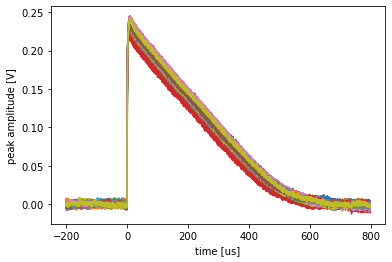

In [11]:
for i in range(len(plot_array)):
    plt.plot(time_axis*1e6, plot_array[i])
    
plt.xlabel('time [us]')
plt.ylabel('peak amplitude [V]')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_traces.png')
    

### This function will extract the peak from each trace/row of the data set. The noise sample is determined by eye; pick a range of x values where there don't appear to be (many) peaks, ex. from 2000:3500.

In [12]:
peaks = f[dsName + '_peaks' ]
integ = f[dsName + "_integral"]

### Plot a histogram of the peaks using matplotlib to get a sense of what the data looks like and where the peak is.

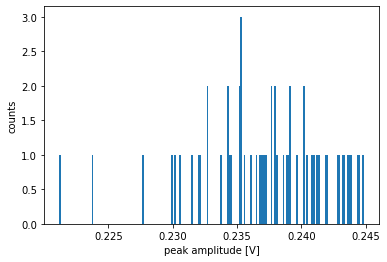

In [13]:
#ultra fine binning for debugging input
plt.hist(peaks, bins=180)
plt.xlabel('peak amplitude [V]')
plt.ylabel('counts')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_runtimePeakHist.png')


# Do the same for the trace integral

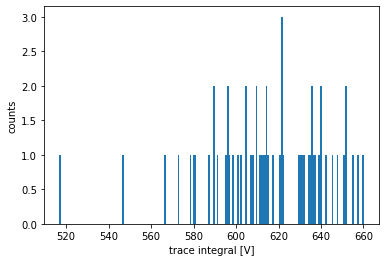

In [14]:
#ultra fine binning for debugging input
plt.hist(integ, bins=180)
plt.xlabel('trace integral [V]')
plt.ylabel('counts')

if savePlots:
    plt.savefig(path+outName+'_'+dsName+'_runtimeIntegHist.png')

### If you are done working with a file, ***make sure you close it!*** h5py does not like it when files are left open and you change files and/or kill the kernel.

In [15]:
f.close()

YOU DID IT!!!